In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 500
predict_for = 14

In [ ]:
def smoothen_freq(df):
  x = df
  nan_indices = np.isnan(x)

  # # Remove the NaN values from the array
  x = x[np.logical_not(nan_indices)]

  # Generate a noisy signal
  signal = x

  # Apply Fourier transform to the signal
  f_signal = np.fft.fft(signal)

  # Calculate the power spectrum
  power = np.abs(f_signal)**2

  # Set a threshold to remove the noise
  threshold = 0.005 * max(power)
  f_signal[power < threshold] = 0

  # Apply inverse Fourier transform to the filtered signal
  filtered_signal = np.fft.ifft(f_signal)

  return filtered_signal


In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
def scale(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

In [ ]:
class Model:
  def __init__(self, df):
    self.model=None
    self.scaler = MinMaxScaler()
    # self.df = smoothen_freq(df)
    self.df = scale(df, self.scaler)
    self.dfw, self.dfy = prepare_data(self.df)

    model_strong = tf.keras.Sequential([
        LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)),
        LSTM(units = 32, return_sequences=True),
        LSTM(units = 32),
        Dense(units = 32)
    ])
    
    model_weak=tf.keras.Sequential([
        LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)),
        Dropout(0.2),
        LSTM(units = 32, return_sequences=True),
        Dropout(0.2),
        LSTM(units = 32),
        Dropout(0.2),
        Dense(units = 32)
    ])

    concatenated=tf.keras.layers.Concatenate()([model_strong.output, model_weak.output])
    l1=tf.keras.layers.Dense(64)(concatenated)
    l2=tf.keras.layers.Dense(32)(l1)
    l3=tf.keras.layers.Dense(16)(l2)
    l4=tf.keras.layers.Dense(1)(l3)


    

    self.model=tf.keras.Model(inputs=[model_strong.input, model_weak.input], outputs=l4)
    self.model.compile(optimizer = 'adam', loss = "mean_squared_error")

    

  def fit(self):
    y_train = self.dfy 
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    self.model.fit([self.dfw, self.dfw], y_train, epochs = 100, callbacks=[callback])
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p = [df_full]
    y_p = []

    for i in range(predict_for):
        yi = self.model.predict([np.array(X_p), np.array(X_p)])
        y_p.append(yi[0][0])
        
        X_p = [np.append(X_p[0][1:], yi)]

    return descaled(y_p, self.scaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
print(df.columns)
print(df.state_residence.unique())

df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()

date = df.iloc[train_for + 1]['Date']

df_f = df['F_pos'].values
df_m = df['M_pos'].values
df_t = df['T_pos'].values
df_nia = df['NIA_pos'].values

df_total = df_f + df_m + df_t + df_nia

# df_total = df['new_case']

# n = 70  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# df_total = lfilter(b, a, df_total)
# df_total = smoothen(df_total, 10)

Index(['Unnamed: 0', 'state_residence', 'district_residence', 'Date', '<15',
       '15-24', '25-34', '35-44', '45-59', '60-80', '>80', '<15_pos',
       '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos',
       '>80_pos', 'M_pos', '2', 'F_pos', 'T', 'F', 'M', 'NIA', 'T_pos',
       'NIA_pos', 'O', 'O_pos', 'N', 'G', ',', 'D', 'new_case',
       'negative_case', 'Failed_test', 'Total_test',
       'negative_egene_screening', 'positive_egene_screening',
       'Failed_test_egene_screening', '<20_ct_value_screening',
       '20-30_ct_value_screening', '31-35_ct_value_screening',
       '>35_ct_value_screening', '<20_posct_value_screening',
       '20-30_posct_value_screening', '31-35_posct_value_screening',
       '>35_posct_value_screening', 'negative_rdrp_confirmatory',
       'positive_rdrp_confirmatory', 'Failed_test_rdrp_confirmatory',
       '<20_ct_value_rdrp', '20-30_ct_value_rdrp', '31-35_ct_value_rdrp',
       '>35_ct_value_rdrp', '<20_posct_value_rdrp', '20-30_po

In [ ]:
model_f = Model(df_f[:train_for])
model_m = Model(df_m[:train_for])
model_t = Model(df_t[:train_for])
model_nia = Model(df_nia[:train_for])

model_f.fit()
model_m.fit()
model_t.fit()
model_nia.fit()

Epoch 1/100
15/15 [==============================] - 16s 119ms/step - loss: 0.0183
Epoch 2/100
15/15 [==============================] - 2s 115ms/step - loss: 0.0076
Epoch 3/100
15/15 [==============================] - 2s 116ms/step - loss: 0.0155
Epoch 4/100
15/15 [==============================] - 2s 162ms/step - loss: 0.0087
Epoch 5/100
15/15 [==============================] - 3s 220ms/step - loss: 0.0058
Epoch 6/100
15/15 [==============================] - 2s 121ms/step - loss: 0.0053
Epoch 7/100
15/15 [==============================] - 2s 122ms/step - loss: 0.0056
Epoch 8/100
15/15 [==============================] - 2s 120ms/step - loss: 0.0042
Epoch 9/100
15/15 [==============================] - 2s 122ms/step - loss: 0.0035
Epoch 10/100
15/15 [==============================] - 2s 121ms/step - loss: 0.0032
Epoch 11/100
15/15 [==============================] - 3s 185ms/step - loss: 0.0033
Epoch 12/100
15/15 [==============================] - 3s 210ms/step - loss: 0.0029
Epoch 13/100

In [ ]:
def mape_(p, a):
  print(len(p))
  print(len(a))
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100

In [ ]:
predictions = model_f.predict(predict_for) + model_m.predict(predict_for) + model_t.predict(predict_for) + model_nia.predict(predict_for)

actual = df_total[train_for:train_for+predict_for]

MAPE = mape_(predictions, actual)
print("MAPE:", MAPE)

1/1 [==============================] - 0s 38ms/step
14
14
MAPE: 19.56017623264679


In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

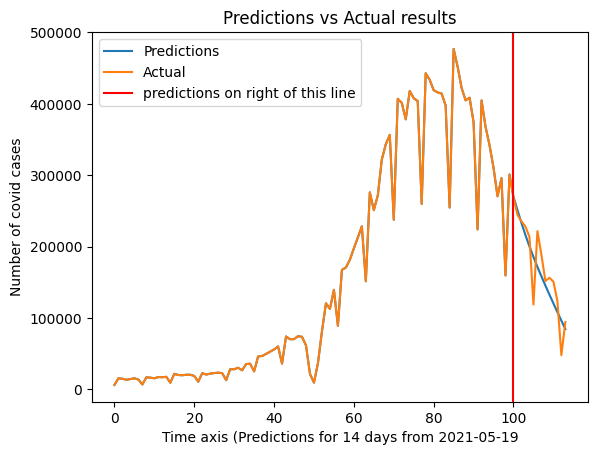

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results")
plt.plot(append(df_total[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df_total[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(predictions)

[269745.7  251135.55 233075.69 216104.83 200308.44 185550.28 171622.19
 158302.25 145428.4  132848.95 120498.89 108327.62  96308.9   84431.62]


In [ ]:
print(actual)

[268203. 244480. 235431. 228071. 213692. 118887. 221694. 188326. 151772.
 156407. 150949. 124081.  47962.  94359.]


In [ ]:
model_f.model.save("model_f" + date + ".h5")
model_m.model.save("model_m" + date + ".h5")
model_t.model.save("model_t" + date + ".h5")
model_nia.model.save("model_nia" + date + ".h5")